# CWL-metrics RNA-seq quantification workflow runtime metrics comparison

[CWL-metrics](https://inutano.github.io/cwl-metrics/) is a system to capture runtime metrics of [CWL](https://www.commonwl.org/) workflow runs to optimize a computational environment selection. This notebook is for an example usage of CWL-metrics that collected runtime metrics of RNA-seq quantification workflows.

This notebook contains:

- Import workflow runtime metrics data generated by CWL-metrics
- Remove failed workflow runs
- Import metadata
  - Sequence read quality (length and number) for each sample data
  - AWS EC2 Instance type details
- Create summary table for instance selection optimization
- Draw boxplot for each workflows x processing duration, max CPU usage, max memory usage
- Draw boxplot for each samples x processing duration, max CPU usage, max memory usage


### Runtime metrics captured by Telegraf

Values of maximum CPU usage, total amount of memory, total amount of memory cache, total amount of blockIO are retrieved for each step of workflows by Telegraf docker plugin. It collects runtime metrics in 60 seconds interval, so the values can vary for workflow runs. The column cpu, mem, cache, and blkio are representing the maximum value of the multiple steps of the workflow.

## Load libraries

- ggplot2 for boxplot
- foreach for iteration

In [20]:
library(ggplot2)
library(foreach)

## Load metrics data from tsv

Use `merge_multiple_metrics.rb` script to merge multiple JSON format CWL-metrics output files to generate input tsv data.

In [31]:
metrics.raw <- read.delim("./workflow_metrics_20180814.tsv")
metrics.raw

workflow_id,workflow_name,workflow_total_duration,download_duration,processing_duration,instance_type,status,run_id,cpu,mem,cache,blkio
b9f8208,hisat2-stringtie_wf_pe.cwl,101,1.4201499,99.579850,c5.2xlarge,success,SRR4250750,785.25683,9902235648,5117796352,4671578112
461e8ee,hisat2-stringtie_wf_pe.cwl,424,2.4873464,421.512654,c5.2xlarge,success,SRR2932901,787.95179,7249924096,2431356928,1205075968
d39aa7f,hisat2-stringtie_wf_pe.cwl,717,4.1160923,712.883908,c5.2xlarge,success,ERR204893,794.45192,10907009024,6065741824,4932296704
69d7bc3,hisat2-stringtie_wf_se.cwl,103,0.6922020,102.307798,c5.2xlarge,success,SRR4428678,753.49942,10043715584,5279178752,4671901696
927373f,hisat2-stringtie_wf_se.cwl,1284,0.9165000,1283.083500,c5.2xlarge,success,SRR4250750,757.82395,7602081792,2906124288,4689362944
e7172e4,hisat2-stringtie_wf_se.cwl,775,8.1725721,766.827428,c5.2xlarge,success,ERR204893,792.55665,11012243456,6182096896,5242511360
47e754f,tophat2-cufflinks_wf_pe.cwl,967,0.8610387,966.138961,c5.2xlarge,success,SRR4250750,796.23503,11155390464,7004672000,6322356224
0da5653,tophat2-cufflinks_wf_se.cwl,4921,4.1404237,4916.859576,c5.2xlarge,success,SRR2932901,665.34162,12784709632,9260752896,12000964608
a104855,tophat2-cufflinks_wf_se.cwl,939,1.6495148,937.350485,c5.2xlarge,success,SRR5168756,631.63834,11563429888,7037349888,6423310336
531d085,tophat2-cufflinks_wf_se.cwl,1407,0.8202008,1406.179799,c5.2xlarge,success,SRR4428678,749.97898,11231010816,7199121408,6390611968


Number of rows for raw data

In [32]:
nrow(metrics.raw)

[1] 3736

In [ ]:
sample.metadata <- read.delim("./")

## Remove failed workflow runs

The values in "status" column will be `success` if all the steps succeeded, otherwise it will be `failed` or `success,failed`.

In [34]:
metrics.failed <- subset(metrics.raw, metrics.raw$status != "success")
metrics.failed

,workflow_id,workflow_name,workflow_total_duration,download_duration,processing_duration,instance_type,status,run_id,cpu,mem,cache,blkio
25,e213a41,star-stringtie_wf_se.cwl,7,0.7888892,6.211111,c5.2xlarge,"success,failed",SRR4250750,0.0000000,0,0,0
57,3850b52,star-stringtie_wf_se.cwl,61,3.5268740,57.473126,c5.2xlarge,"success,failed",SRR2932901,11.1263816,5054058496,5053059072,0
58,2203293,star-cufflinks_wf_se.cwl,6,0.3206436,5.679356,c5.2xlarge,"success,failed",SRR4250750,0.0000000,0,0,0
59,368557d,star-stringtie_wf_se.cwl,143,4.7595936,138.240406,c5.2xlarge,"success,failed",ERR204893,0.7526371,5744443392,5743915008,948613120
68,c6d6fa1,star-cufflinks_wf_pe.cwl,175,19.6985026,155.301497,c5.2xlarge,"success,failed",SRR2567462,2.7456299,8970833920,8952430592,3830108160
69,5cb16e3,star-cufflinks_wf_pe.cwl,57,2.1548558,54.845144,c5.2xlarge,"success,failed",SRR5023408,0.0000000,0,0,0
70,6a7b908,star-stringtie_wf_pe.cwl,36,2.3827665,33.617234,c5.2xlarge,"success,failed",SRR5185518,0.0000000,0,0,0
71,387ecc1,star-cufflinks_wf_se.cwl,34,2.3546890,31.645311,c5.2xlarge,"success,failed",SRR5185518,0.0000000,0,0,0
72,1144f1b,star-stringtie_wf_se.cwl,7,1.1125290,5.887471,c5.2xlarge,"success,failed",SRR4250750,0.0000000,0,0,0
73,4d4439e,star-stringtie_wf_se.cwl,6,0.7476765,5.252323,c5.2xlarge,"success,failed",SRR4428678,0.0000000,0,0,0


In [35]:
nrow(metrics.failed)

[1] 406

Runtime metrics data of succeeded workflows

In [108]:
metrics <- subset(metrics.raw, metrics.raw$status == "success")
metrics

,workflow_id,workflow_name,workflow_total_duration,download_duration,processing_duration,instance_type,status,run_id,cpu,mem,cache,blkio
1,b9f8208,hisat2-stringtie_wf_pe.cwl,101,1.4201499,99.57985,c5.2xlarge,success,SRR4250750,785.25683,9902235648,5117796352,4671578112
2,461e8ee,hisat2-stringtie_wf_pe.cwl,424,2.4873464,421.51265,c5.2xlarge,success,SRR2932901,787.95179,7249924096,2431356928,1205075968
3,d39aa7f,hisat2-stringtie_wf_pe.cwl,717,4.1160923,712.88391,c5.2xlarge,success,ERR204893,794.45192,10907009024,6065741824,4932296704
4,69d7bc3,hisat2-stringtie_wf_se.cwl,103,0.6922020,102.30780,c5.2xlarge,success,SRR4428678,753.49942,10043715584,5279178752,4671901696
5,927373f,hisat2-stringtie_wf_se.cwl,1284,0.9165000,1283.08350,c5.2xlarge,success,SRR4250750,757.82395,7602081792,2906124288,4689362944
6,e7172e4,hisat2-stringtie_wf_se.cwl,775,8.1725721,766.82743,c5.2xlarge,success,ERR204893,792.55665,11012243456,6182096896,5242511360
7,47e754f,tophat2-cufflinks_wf_pe.cwl,967,0.8610387,966.13896,c5.2xlarge,success,SRR4250750,796.23503,11155390464,7004672000,6322356224
8,0da5653,tophat2-cufflinks_wf_se.cwl,4921,4.1404237,4916.85958,c5.2xlarge,success,SRR2932901,665.34162,12784709632,9260752896,12000964608
9,a104855,tophat2-cufflinks_wf_se.cwl,939,1.6495148,937.35049,c5.2xlarge,success,SRR5168756,631.63834,11563429888,7037349888,6423310336
10,531d085,tophat2-cufflinks_wf_se.cwl,1407,0.8202008,1406.17980,c5.2xlarge,success,SRR4428678,749.97898,11231010816,7199121408,6390611968


In [37]:
nrow(metrics)

[1] 3330

### Summarization

In [107]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
duration.mean <- aggregate(cbind(workflow_total_duration, cpu, mem, cache, blkio) ~ run_id+workflow_name+instance_type, data=metrics, median)
duration.mean$run_id <- factor(duration.mean$run_id, levels=runs)
duration.mean[order(duration.mean$run_id, duration.mean$workflow_name),]

,run_id,workflow_name,instance_type,workflow_total_duration,cpu,mem,cache,blkio
5,SRR4250750,hisat2-cufflinks_wf_pe.cwl,c5.2xlarge,181.0,668.91832,2420336640,320030720,1042432
95,SRR4250750,hisat2-cufflinks_wf_pe.cwl,c5.4xlarge,117.0,31.94063,2266734592,100954112,0
185,SRR4250750,hisat2-cufflinks_wf_pe.cwl,m5.2xlarge,189.0,697.07943,2751954944,861671424,861933568
275,SRR4250750,hisat2-cufflinks_wf_pe.cwl,m5.4xlarge,127.0,0.00000,2643492864,163807232,0
401,SRR4250750,hisat2-cufflinks_wf_pe.cwl,r5.2xlarge,173.0,685.00135,1874366464,149983232,0
527,SRR4250750,hisat2-cufflinks_wf_pe.cwl,r5.4xlarge,123.0,1225.74084,2347950080,141713408,0
14,SRR4250750,hisat2-cufflinks_wf_se.cwl,c5.2xlarge,203.0,749.25263,6519486464,3280832512,3187949568
104,SRR4250750,hisat2-cufflinks_wf_se.cwl,c5.4xlarge,158.0,1120.19552,5831864320,2898587648,2898751488
194,SRR4250750,hisat2-cufflinks_wf_se.cwl,m5.2xlarge,213.0,666.85850,6671355904,3312410624,3312410624
284,SRR4250750,hisat2-cufflinks_wf_se.cwl,m5.4xlarge,166.0,1242.65774,6139265024,3049967616,3050065920


## Draw boxplot for each workflows

a function to generate title of plots

In [86]:
workflowName2PlotTitle <- function(str){
    str <- gsub(".cwl", "", str)
    str <- gsub("_", " ", str)
    str <- gsub("wf", "workflow", str)
    str <- gsub("se", "single-end", str)
    str <- gsub("pe", "paired-end", str)
    return(str)
}

#### Processing duration of workflows per sample

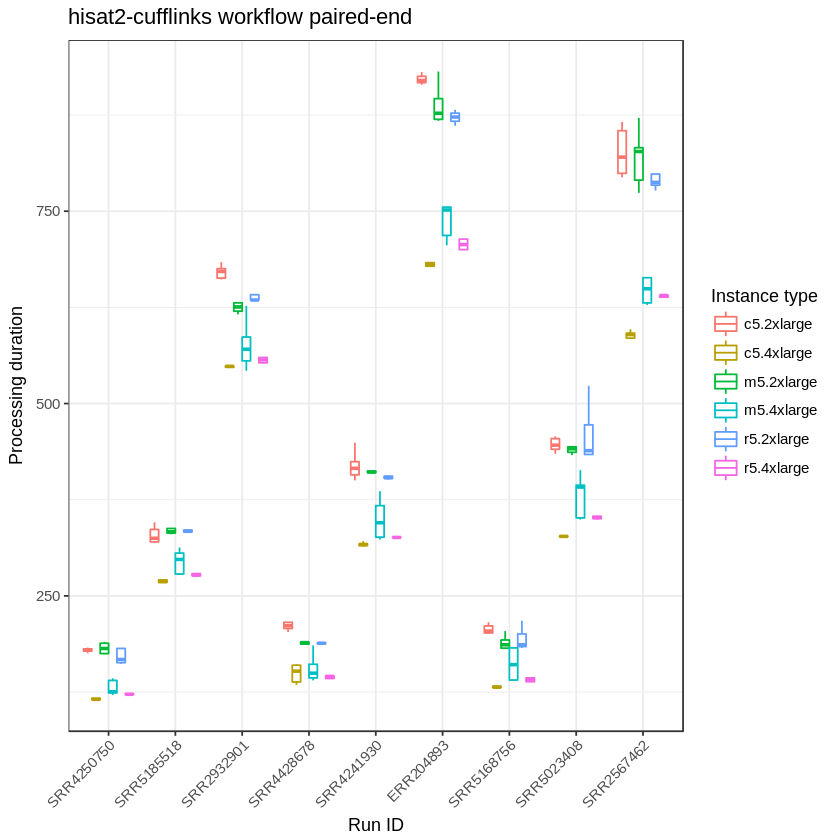

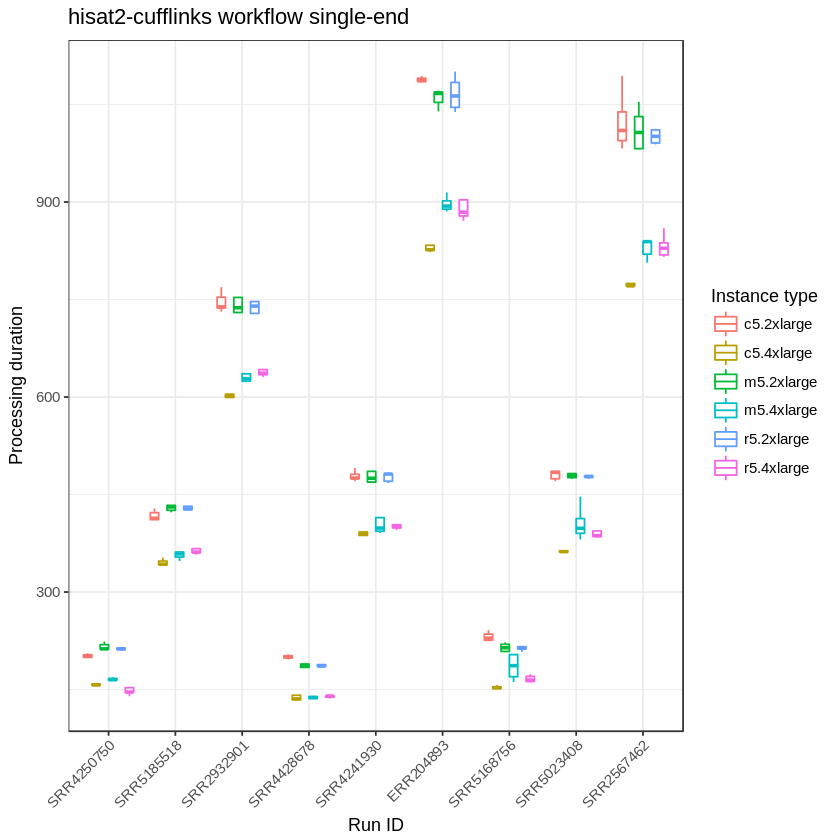

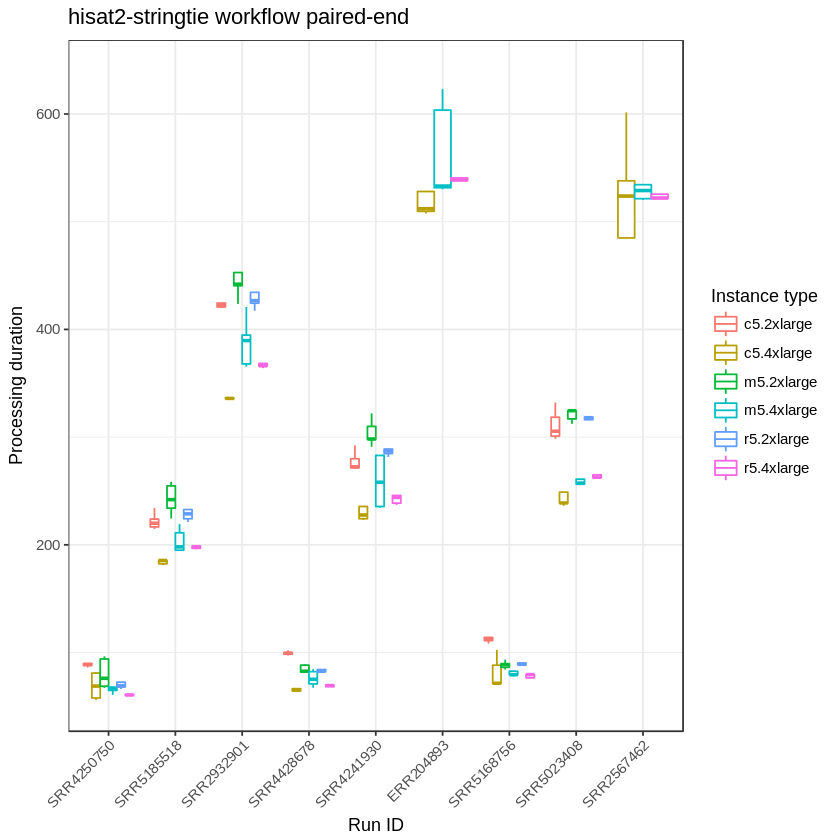

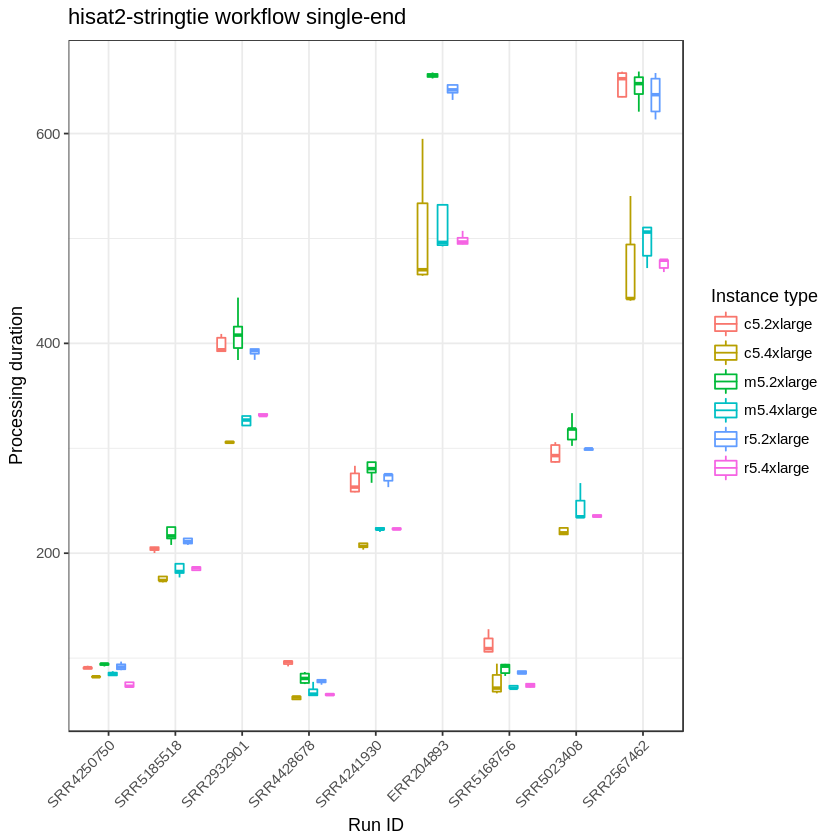

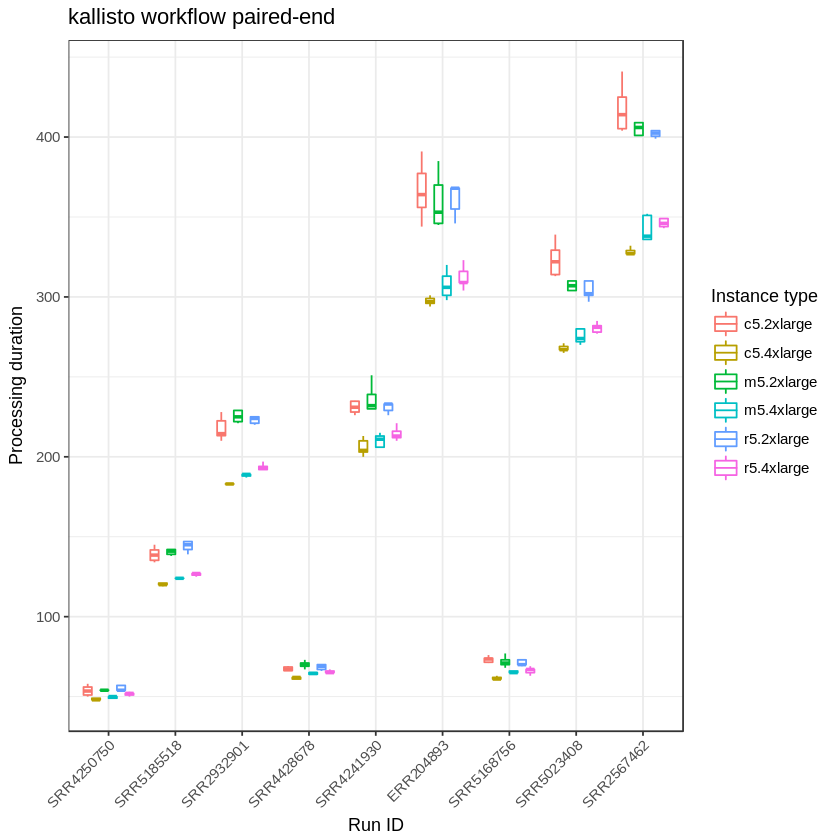

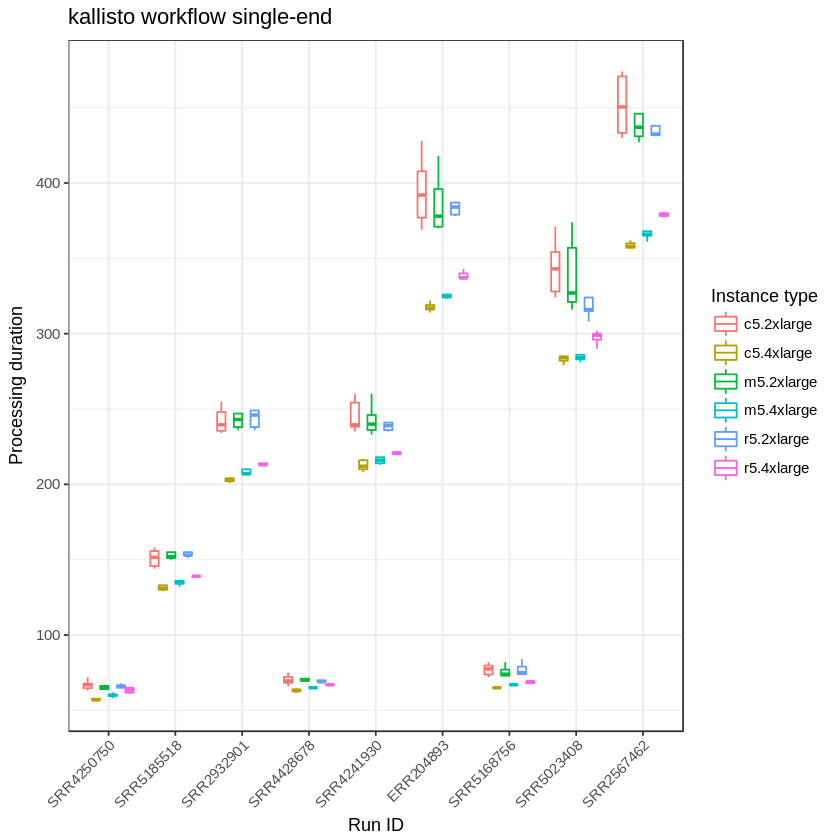

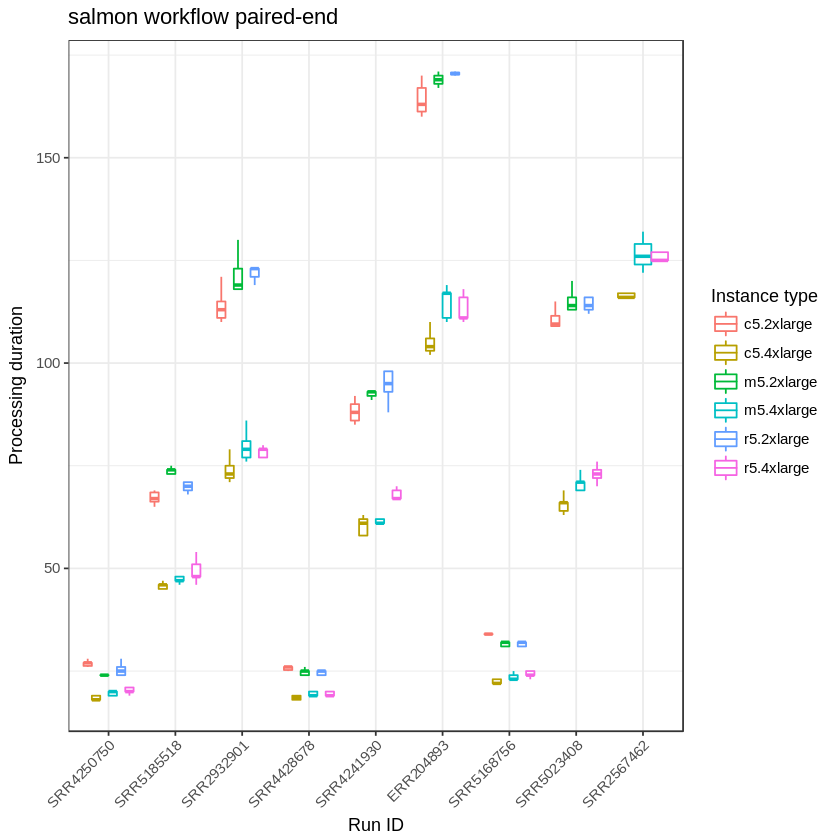

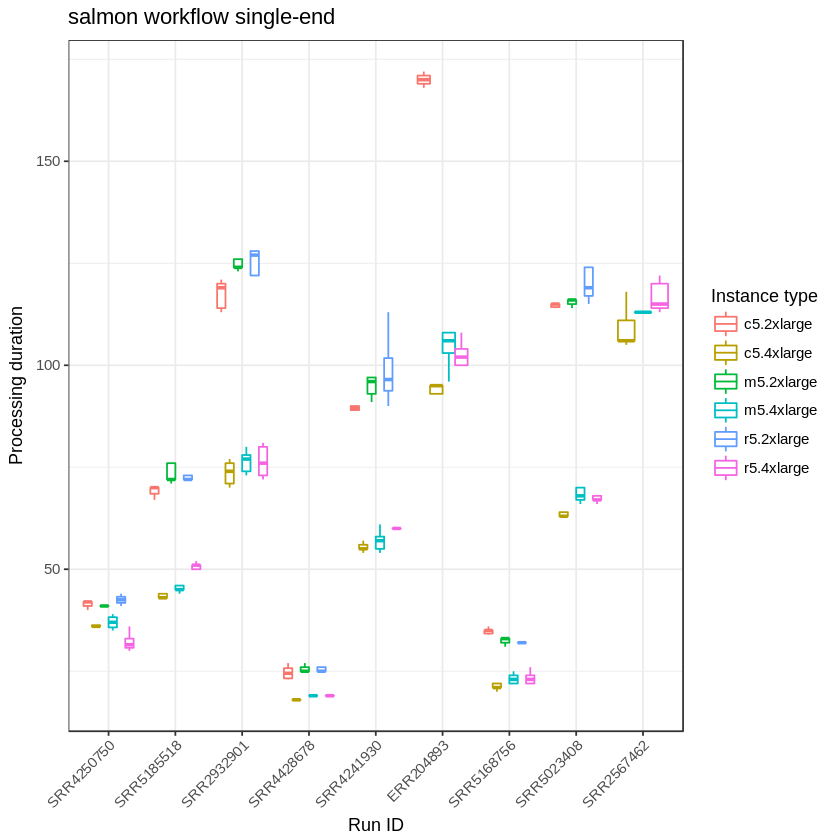

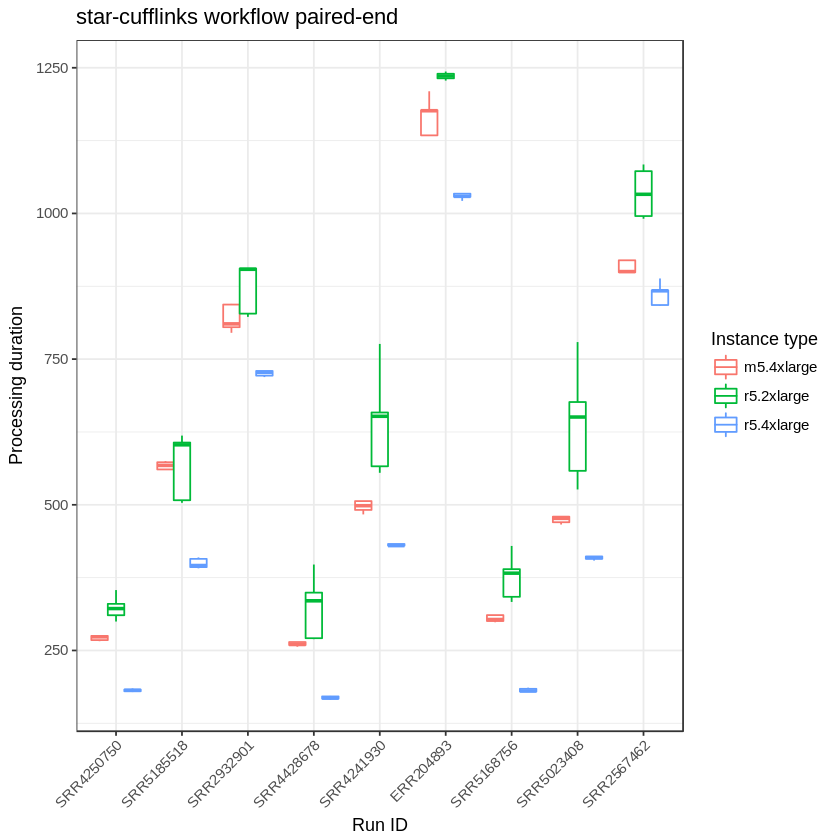

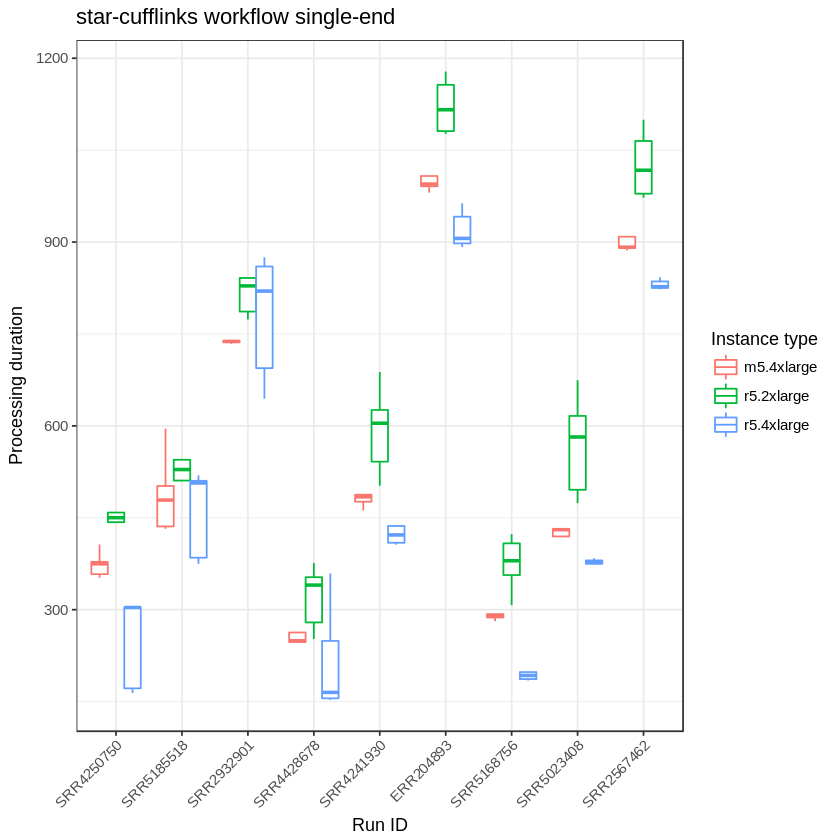

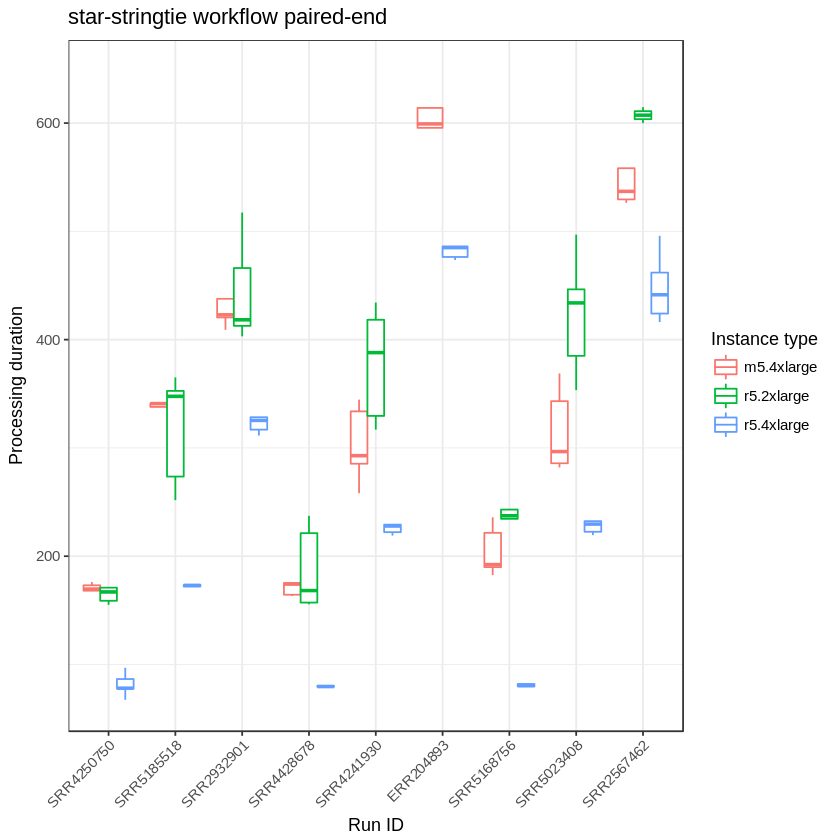

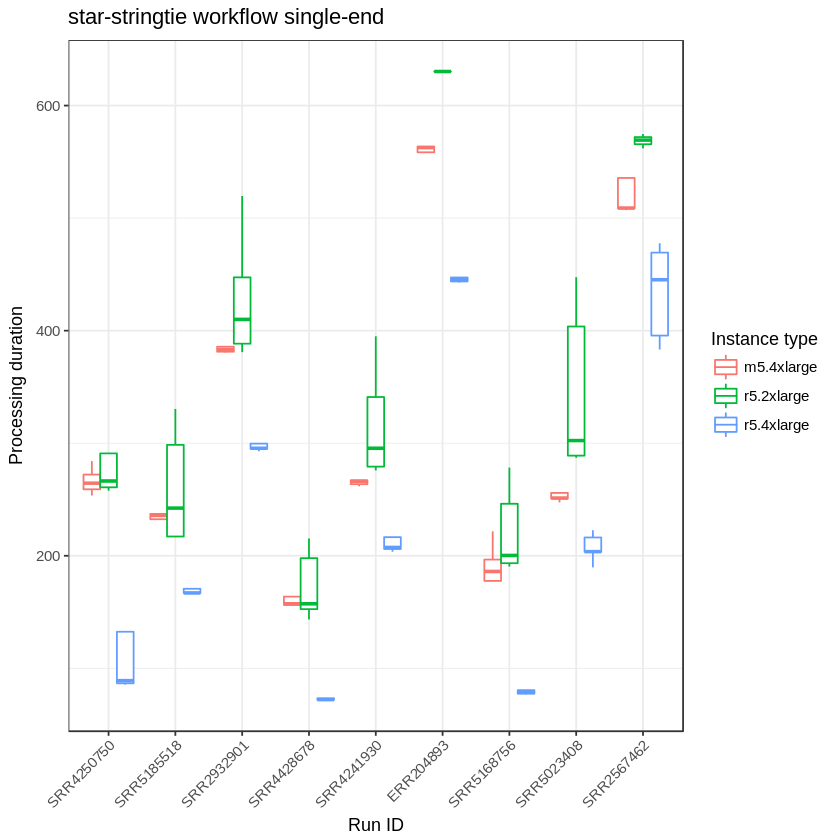

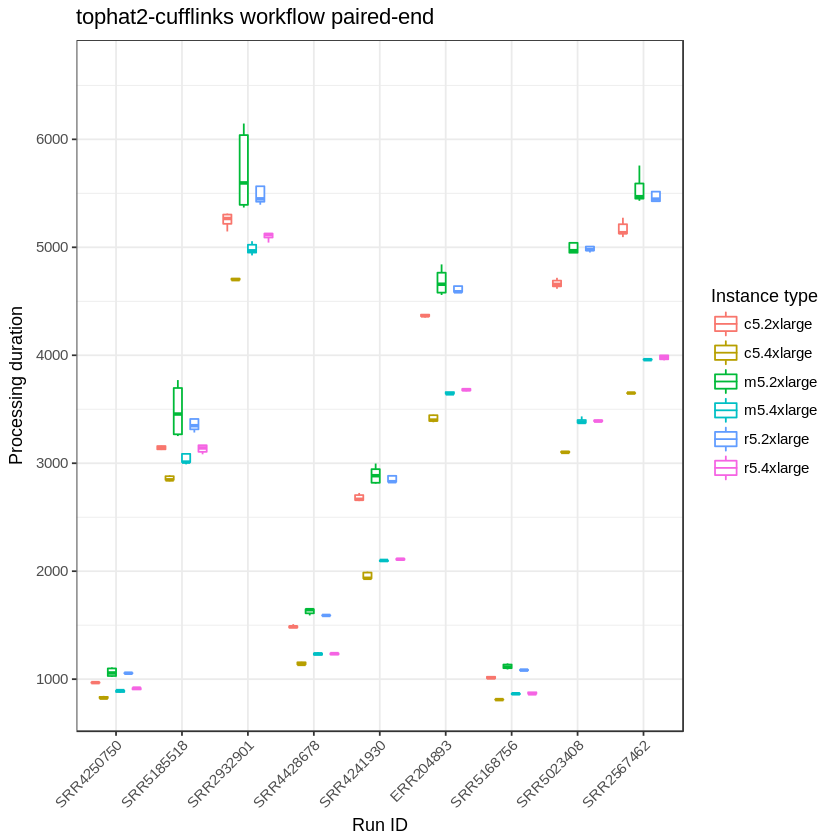

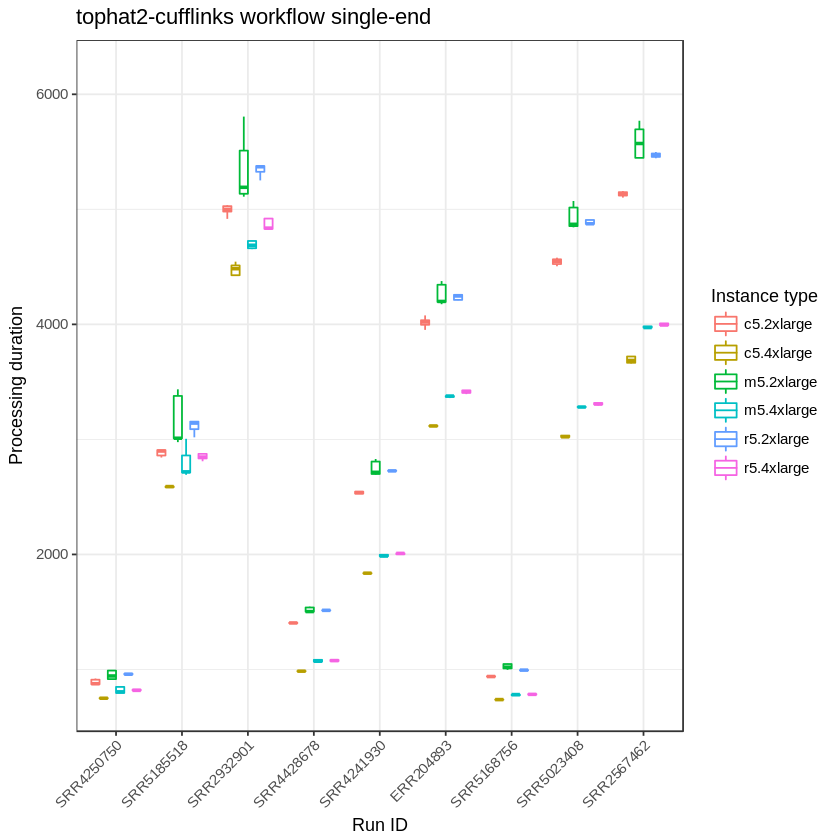

In [88]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=processing_duration, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Processing duration", colour="Instance type")
    
    print(p)
}

#### Maximum CPU usage per sample

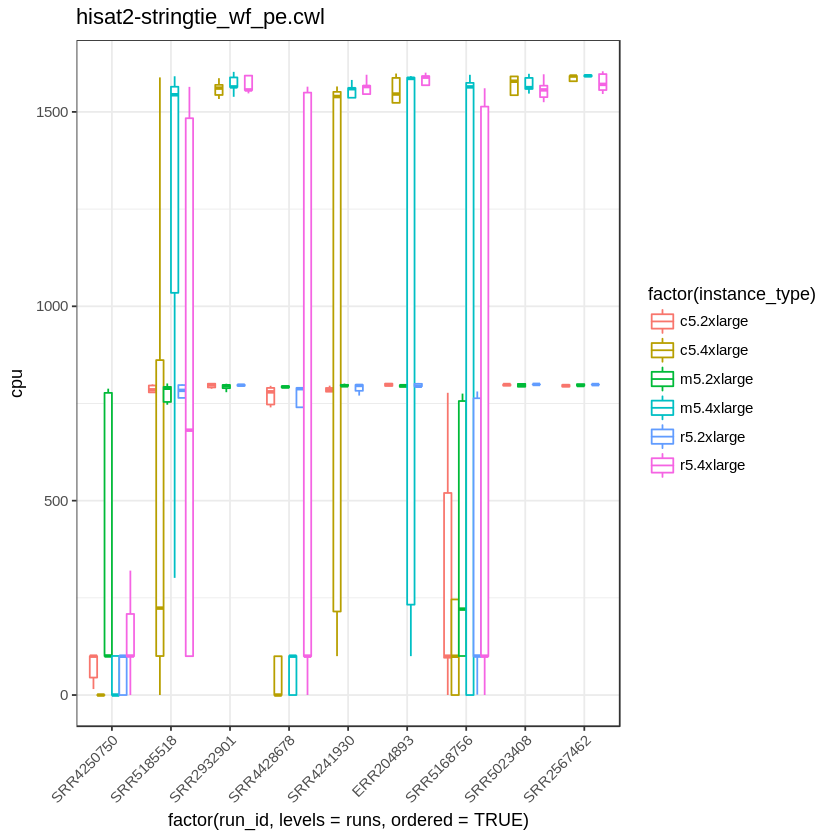

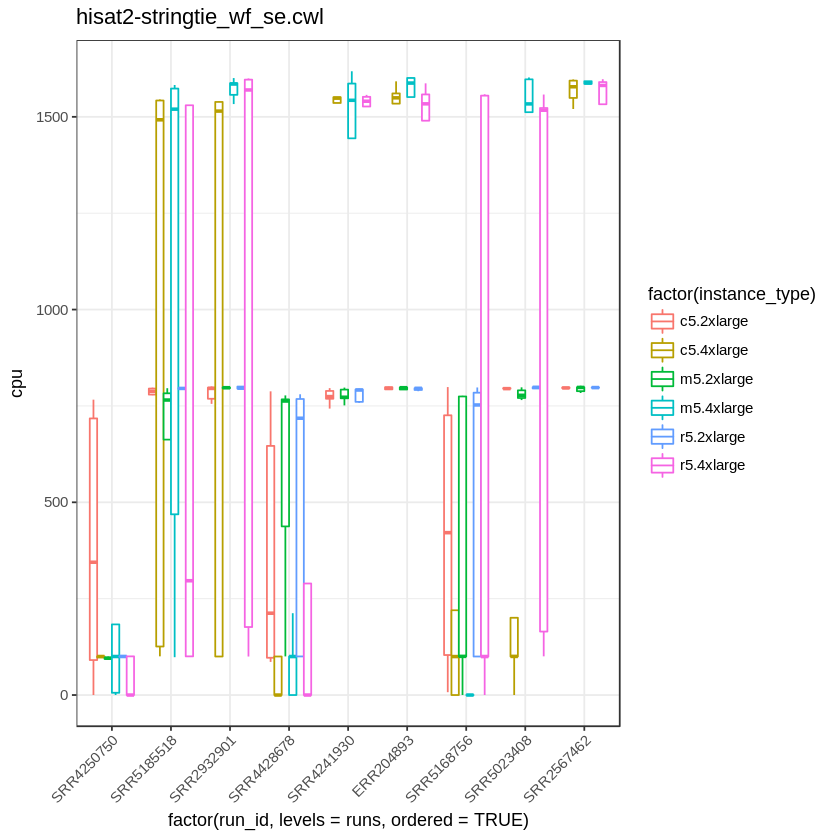

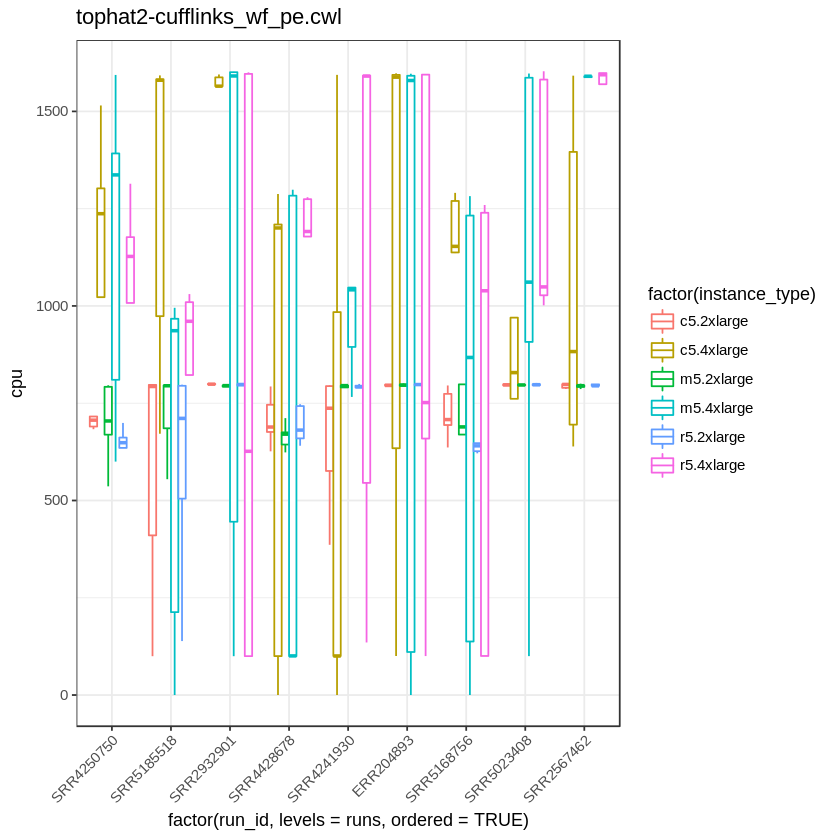

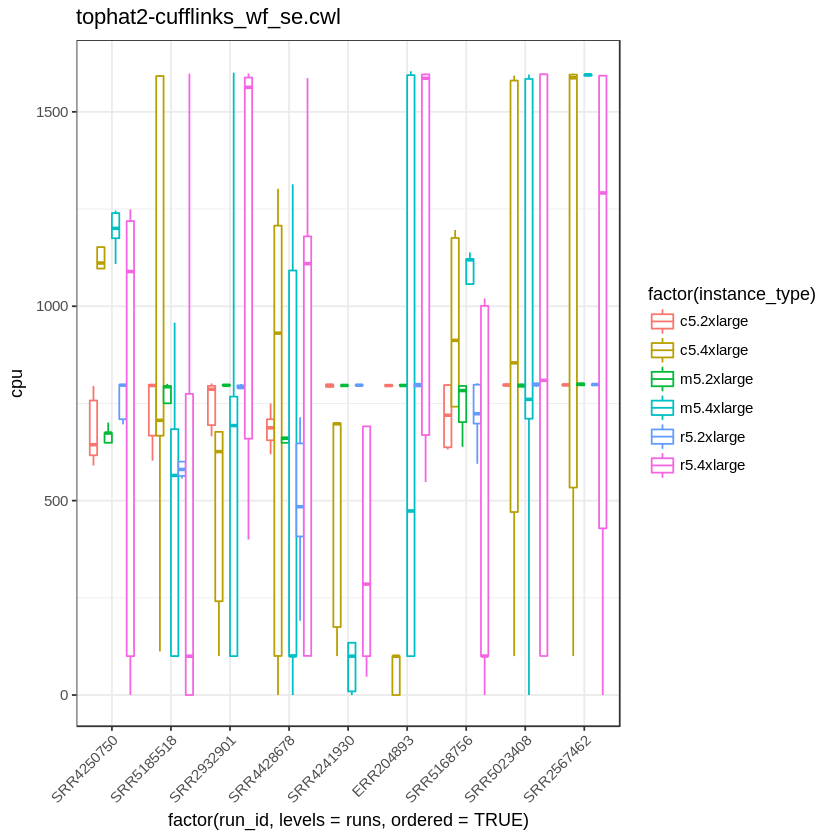

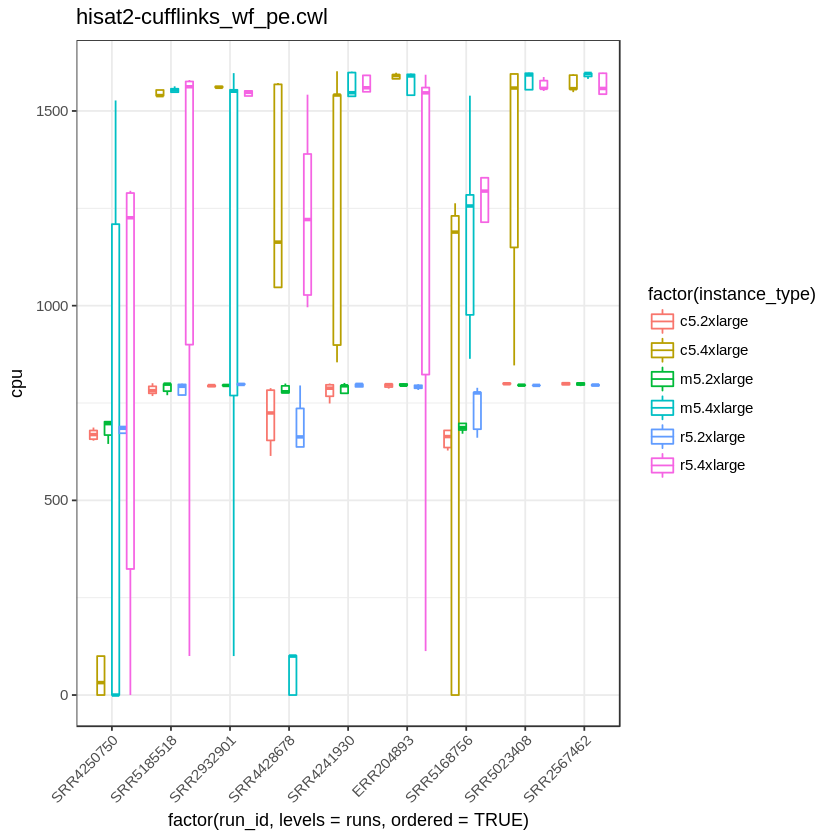

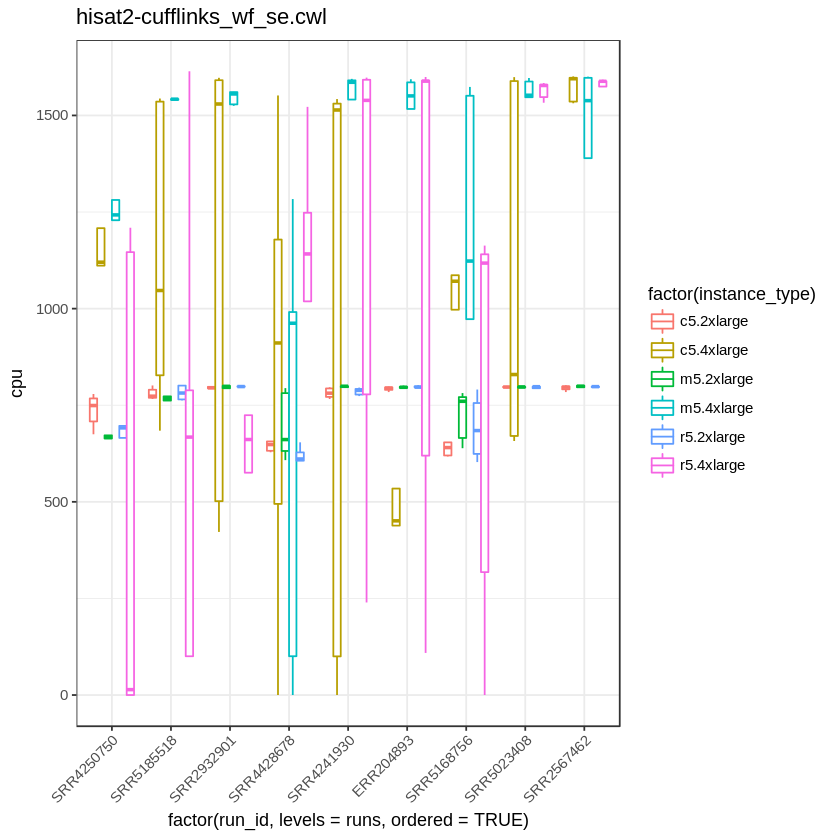

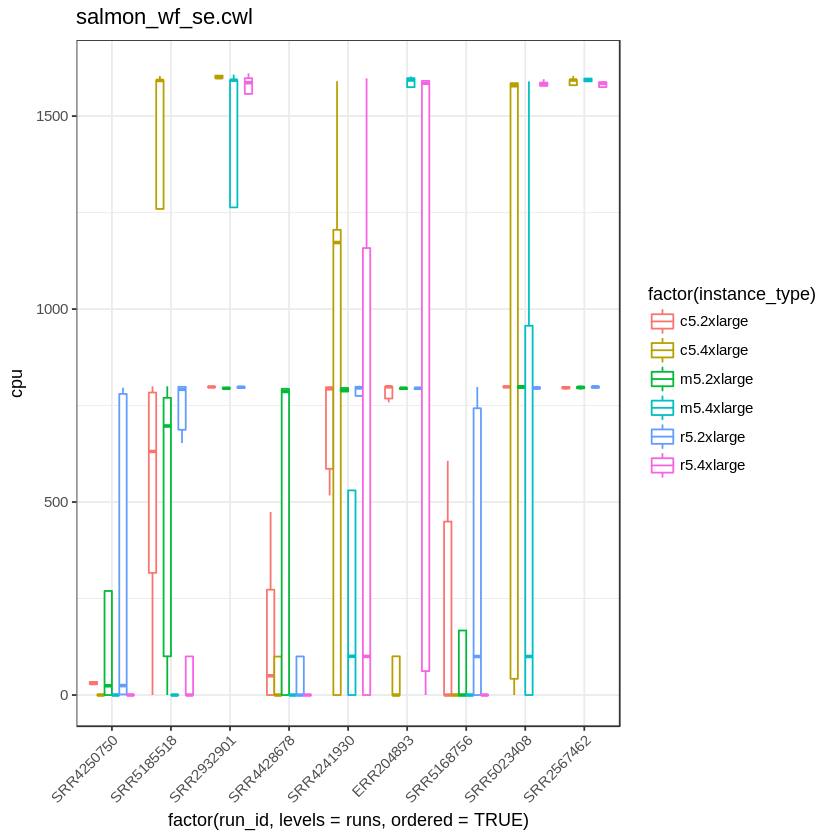

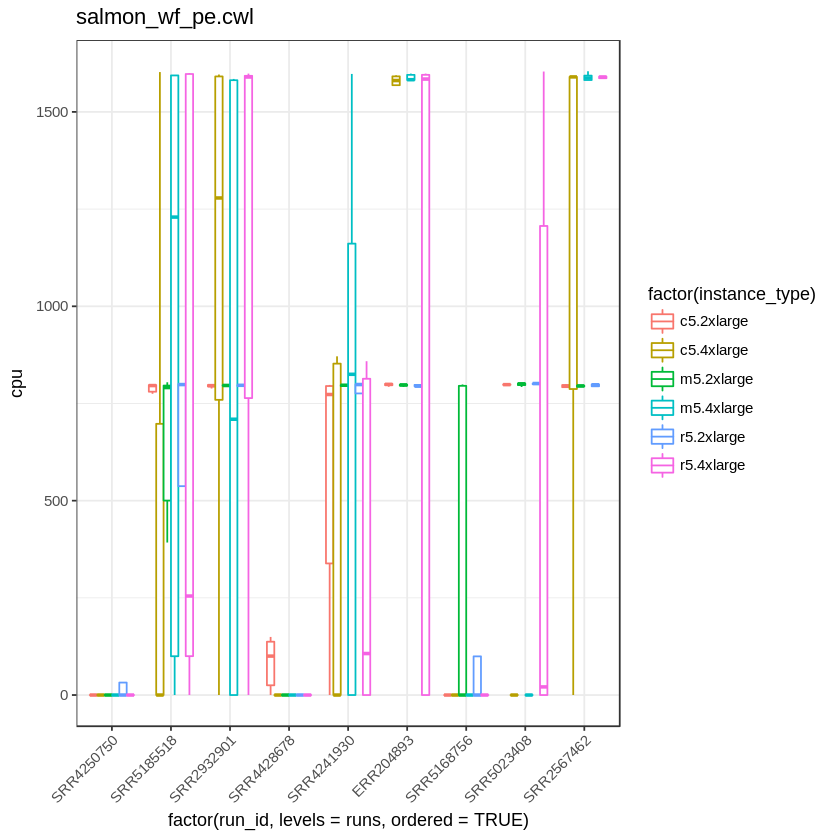

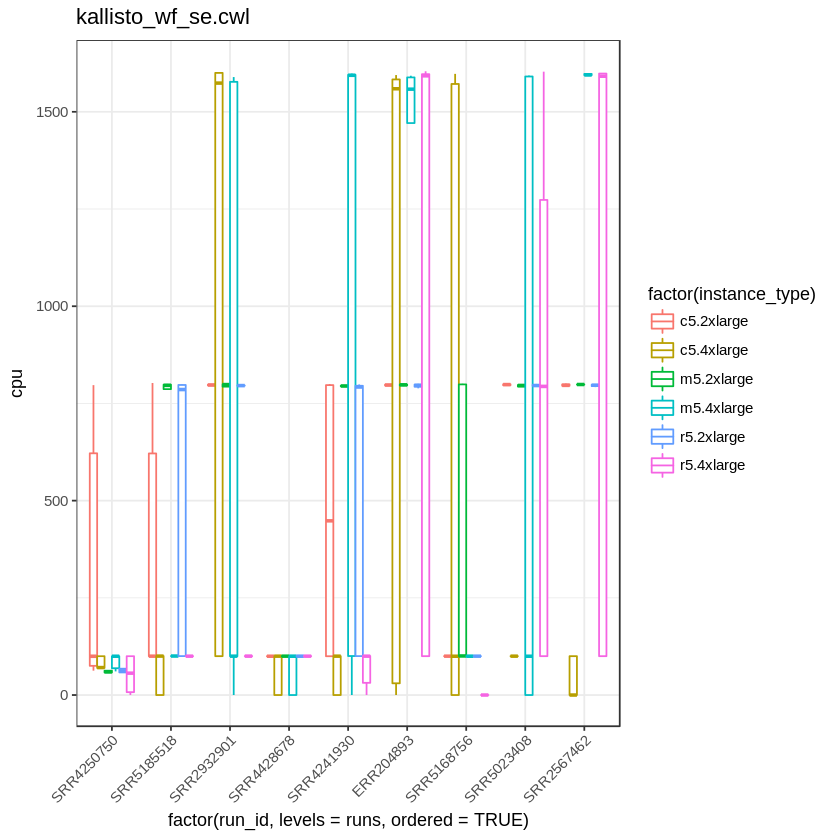

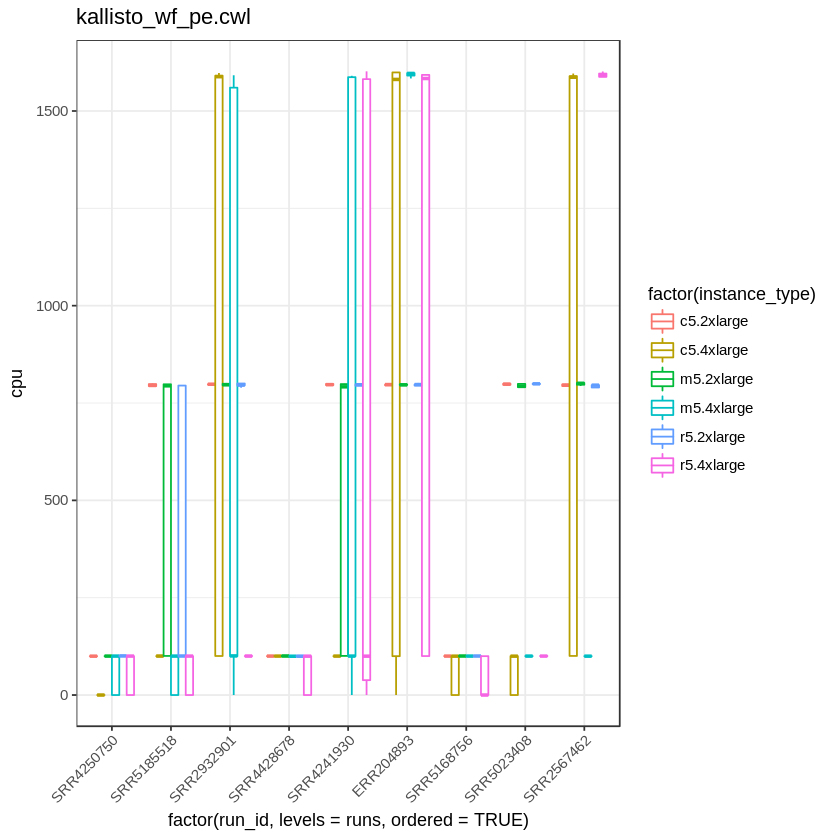

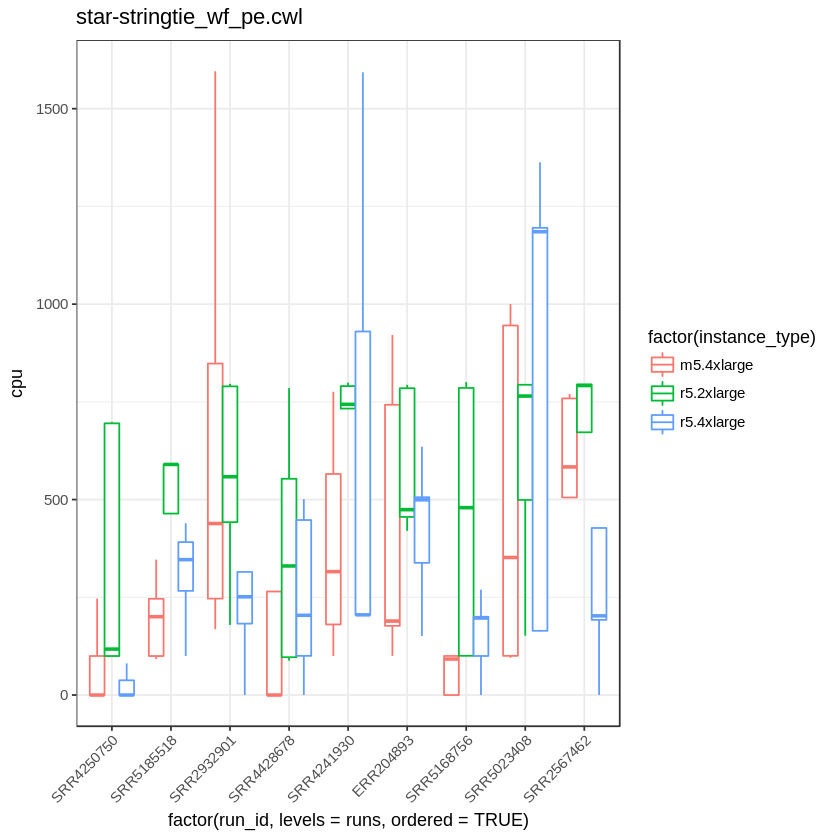

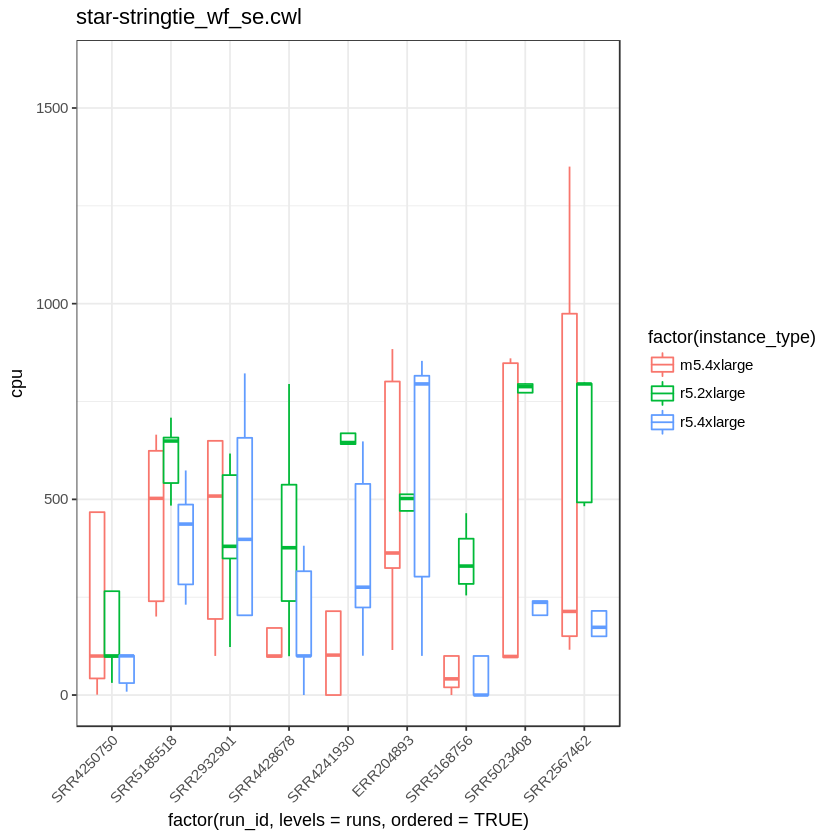

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]


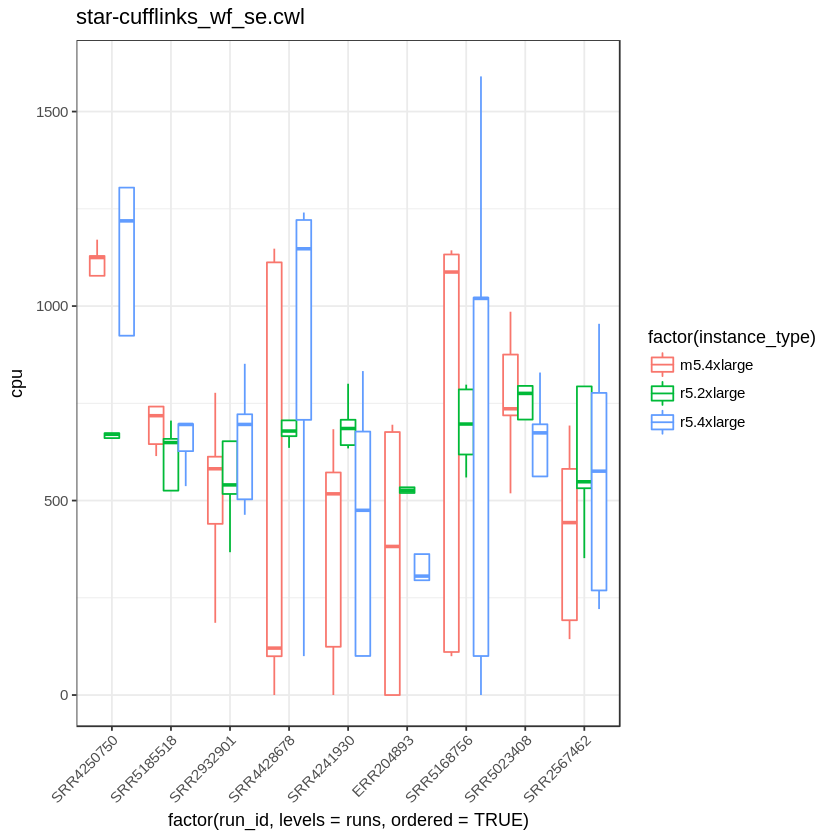

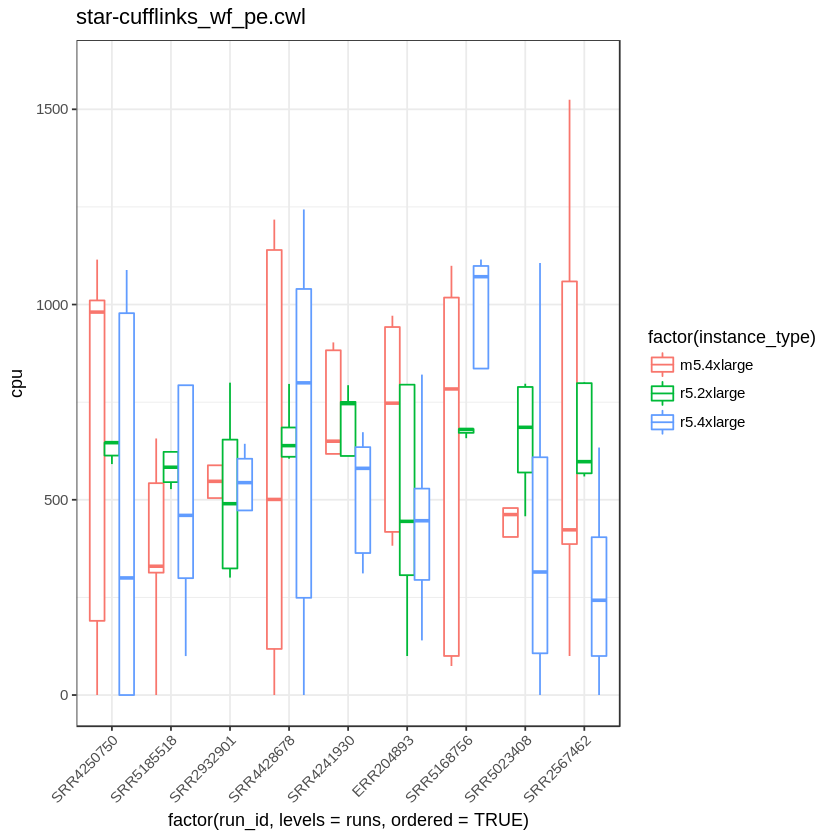

In [75]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- unique(data$workflow_name)
foreach(i=1:NROW(workflow_name)) %do% {
    wf_name <- workflow_name[i]
    d <- subset(data, workflow_name == wf_name)
    #d <- subset(d, processing_duration < summary(d$cpu)[5]*1.5)
    
    
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=cpu, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=wf_name)
}